<a href="https://colab.research.google.com/github/vasisvaran/Deep-Learning-Papers-Reading-Roadmap/blob/master/Week7/Assignment/MSDS453_Assignment_03_v25_20231025_LSTM_Sentiment_Ex3_Voc_512_Dense_2_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization.

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [2]:
!python -m spacy download en_core_web_lg -q

2023-10-31 17:48:31.449711: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 17:48:31.449783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 17:48:31.449830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 17:48:34.415645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### NLTK Downloads

In [5]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [6]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [7]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [9]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc):
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
  df_sample = df.sample(frac=1, random_state=12)
  indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
  train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
  return train_ds, val_ds, test_ds

## Visualization Utility Functions

In [10]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Loading the Class Corpus

In [11]:
CORPUS_PATH=\
'/content/gdrive/MyDrive/Temp/MSDS453/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [12]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Tokenize Words

In [13]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, outnumber, outgunne, mike, b...
91    [sleepy, dopey, action, bonanza, angel, fall, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [improve, blandness, mike, banning, gerard, bu...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

In [14]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Reassemble Leminized Words

In [15]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [16]:
corpus_df['lemmas_joined'].head()

Doc_ID
90    target heavily outnumber outgunne mike banning...
91    sleepy dopey action bonanza angel fall disappo...
92    angel fall mark time gerard butler secret serv...
93    improve blandness mike banning gerard butler w...
94    review contain spoiler angel fallen movie extr...
Name: lemmas_joined, dtype: object

In [17]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Vocabulary Data Wrangling

In [57]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 8802
Curated Vocabulary size: 1774


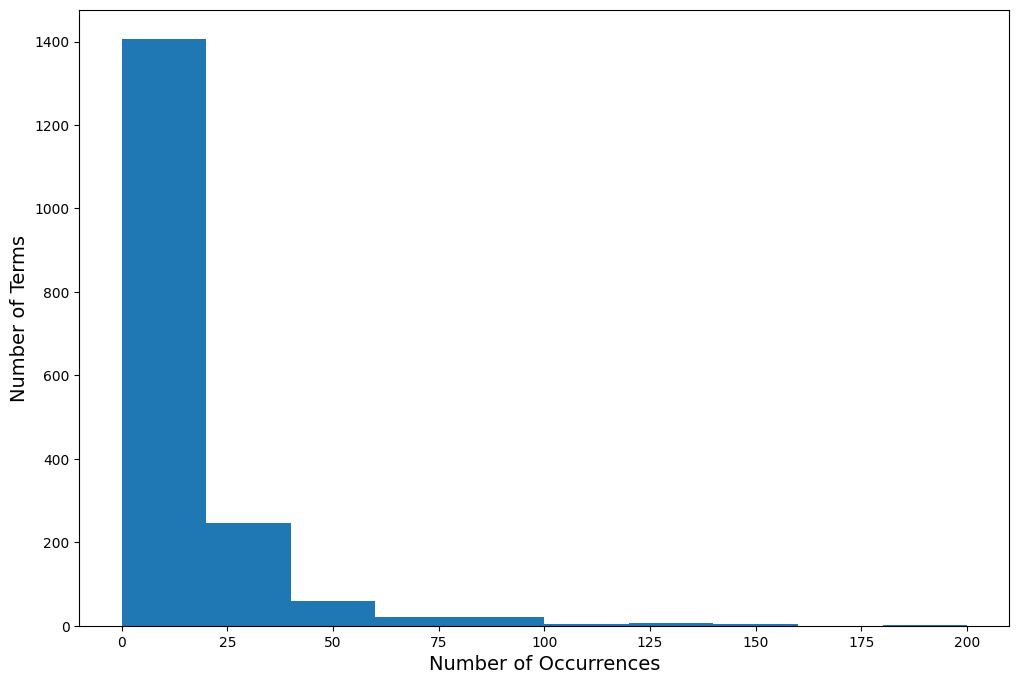

In [58]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [59]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, mike, banning, gerard, butle...
91    [action, angel, fall, reason, expect, second, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [mike, banning, gerard, butler, accept, promot...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words

In [60]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [61]:
corpus_df.head().T

Doc_ID,90,91,92,93,94
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...,This review may contain spoilers . Angel Has F...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93,Action_Angel_has_fallen_N_94
Doc_ID,90,91,92,93,94
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...,"[Improving through blandness ., So Mike Bannin...","[This review may contain spoilers ., Angel Has..."


## Review Documents By Movie Title

In [62]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


In [63]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Taxi'].copy()
movie_df.head(3).T

Doc_ID,65,66,67
DSI_Title,VGI_Doc6_Taxi,VGI_Doc7_Taxi,VGI_Doc8_Taxi
Text,This is quite simply the french version of US ...,This has to be the biggest pile of pap i have ...,"When I rented this movie , I expected it to be..."
Submission File Name,VGI_Doc6_Taxi,VGI_Doc7_Taxi,VGI_Doc8_Taxi
Student Name,VGI,VGI,VGI
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Taxi,Taxi,Taxi
Descriptor,Action_Taxi_N_65,Action_Taxi_N_66,Action_Taxi_N_67
Doc_ID,65,66,67
raw_sentences,[This is quite simply the french version of US...,[This has to be the biggest pile of pap i have...,"[When I rented this movie , I expected it to b..."


## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [64]:
datafull=corpus_df.copy()
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93
Doc_ID,90,91,92,93
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...,"[Improving through blandness ., So Mike Bannin..."


In [65]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet

In [66]:
data = datafull[['Text','Review Type (pos or neg)']].copy()

In [67]:
data['Review Type (pos or neg)'] = data['Review Type (pos or neg)'].astype("category")
data['Review Type (pos or neg) Code'] = data['Review Type (pos or neg)'].cat.codes
data['Review Type (pos or neg) Code'].tail().T

195    1
196    1
197    1
198    1
199    1
Name: Review Type (pos or neg) Code, dtype: int8

## Review Examples by Sentiment

In [68]:
features, targets = data['Text'], data['Review Type (pos or neg) Code']
data[["Review Type (pos or neg)","Review Type (pos or neg) Code"]].value_counts()

Review Type (pos or neg)  Review Type (pos or neg) Code
Negative                  0                                100
Positive                  1                                100
dtype: int64

## Create Datasets for Model Development

In [69]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Review Type (pos or neg) Code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

## Convert DataFrame to TensorFlow DataSet

In [70]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
)
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Review Type (pos or neg) Code'].values, tf.int64),
  )
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
)
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Review Type (pos or neg) Code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
)
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Review Type (pos or neg) Code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [71]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [72]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Text                           200 non-null    object  
 1   Review Type (pos or neg)       200 non-null    category
 2   Review Type (pos or neg) Code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.2+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [74]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [75]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [76]:
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', 'movie', 'nt', 'like', 'one',
       'it', 'time', 'character', 'even', 'get', 'make', 'also', 'two',
       'story', 'action'], dtype='<U19')

In [77]:
vocab[-20:]

array(['thunderbolt', 'thug', 'thud', 'throwing', 'throwback',
       'throwaway', 'through', 'throe', 'throatclenching', 'thrives',
       'thrive', 'threaten', 'thrash', 'thowy', 'thousand',
       'thoughtpoliceman', 'thoughtlessly', 'thornberries', 'thong',
       'thomas'], dtype='<U19')

## Example of Encoded Words

In [78]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  220, 1384,  584, 2920,    1,  106,  106])

In [79]:
len(encoder.get_vocabulary())

5000

In [80]:
encoder(data['Text'][0])

<tf.Tensor: shape=(276,), dtype=int64, numpy=
array([1048,  363,  852,    1,    1,  118,  188,  674,  419, 3155,    1,
          1,    1, 1243,    1,  493,    1,  461,  729,   25, 1228,  532,
          2,  940, 4222,    1,  442, 1566,  258,    2, 3479, 1665,  109,
       2199,   27,  378,  146,  639,    1, 3244,  279,  985,    2,  969,
         32,  281,   75,   77, 1037, 1001,  188, 4307,  502,  325,   55,
        164,  374,  165, 1440,  710,  662,  613,   25,  208,   33,   22,
        259,  643, 1535,  165,  400, 3598,  118,    7,  627,    2, 1076,
        815,  694, 2108,  361,  486,  310, 2916, 3444, 1930,    1, 2625,
          7,  160,  257,  620,   94,  331, 3650, 2461, 2473,    1,   97,
          1,   20,  376, 1433,  202,    1,  931,  954, 1307,   87, 1454,
       1602, 1682, 1998,  239, 1538, 1928, 4115, 4149,  236,    1,    1,
         45,  267,  188,    2,    1,    1, 3055, 1000,  333, 2111, 4066,
       3041, 3156,  907,  519,   33, 3504, 1981, 4129,  163,   61, 1672,
     

In [81]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"In vein `` Remember Titans , `` `` The Rookie `` `` Miracle , `` `` The Finest Hours `` latest Disney film inspired true event . The story one U.S. Coast Guard 's daring rescue mission compelling , done justice . It 's uneven thriller focus wrong side equation , result film never soar high . Set New England coast 1952 , Chris Pine play Bernie , lovable member Coast Guard gotten engaged Miriam ( Holliday Grainger ) . Bernie go announce engagement commanding officer ( Eric Bana ) , sent blizzard rescue oil tanker split half sinking coast . Bernie small crew including severely underused Ben Foster set find rescue survivor , despite condition long odds . The screenplay `` The Finest Hours `` ( credited three writer ) opts focus Bernie Miriam 's budding romance including lengthy prologue met . There also subplot previous rescue mission Bernie ended tragically , feel like plot device used add tension . Grainger 's performance quickly wear thin , character supposed come headstrong 

## Build RNN Sequential Model

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [82]:
k.clear_session()
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 512, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(16, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')
])

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 512)         2560000   
                                                                 
 bidirectional (Bidirection  (None, None, 512)         1574912   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                        

In [84]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [85]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 251s 4s/step - loss: 0.7871 - accuracy: 0.5220 - val_loss: 0.6941 - val_accuracy: 0.5556
Epoch 2/200
53/53 [==============================] - 250s 5s/step - loss: 0.7082 - accuracy: 0.4591 - val_loss: 0.7147 - val_accuracy: 0.3333
Epoch 3/200
53/53 [==============================] - 229s 4s/step - loss: 0.7051 - accuracy: 0.4277 - val_loss: 0.6890 - val_accuracy: 0.5556
CPU times: user 18min 29s, sys: 28.4 s, total: 18min 57s
Wall time: 12min 51s


## Model Performance Test Accuracy

In [86]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 2s 325ms/step - loss: 0.6714 - accuracy: 0.6667
Test Loss: 0.6713995337486267
Test Accuracy: 0.6666666865348816


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [87]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.787,0.522,0.694,0.556
1,0.708,0.459,0.715,0.333
2,0.705,0.428,0.689,0.556


In [89]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

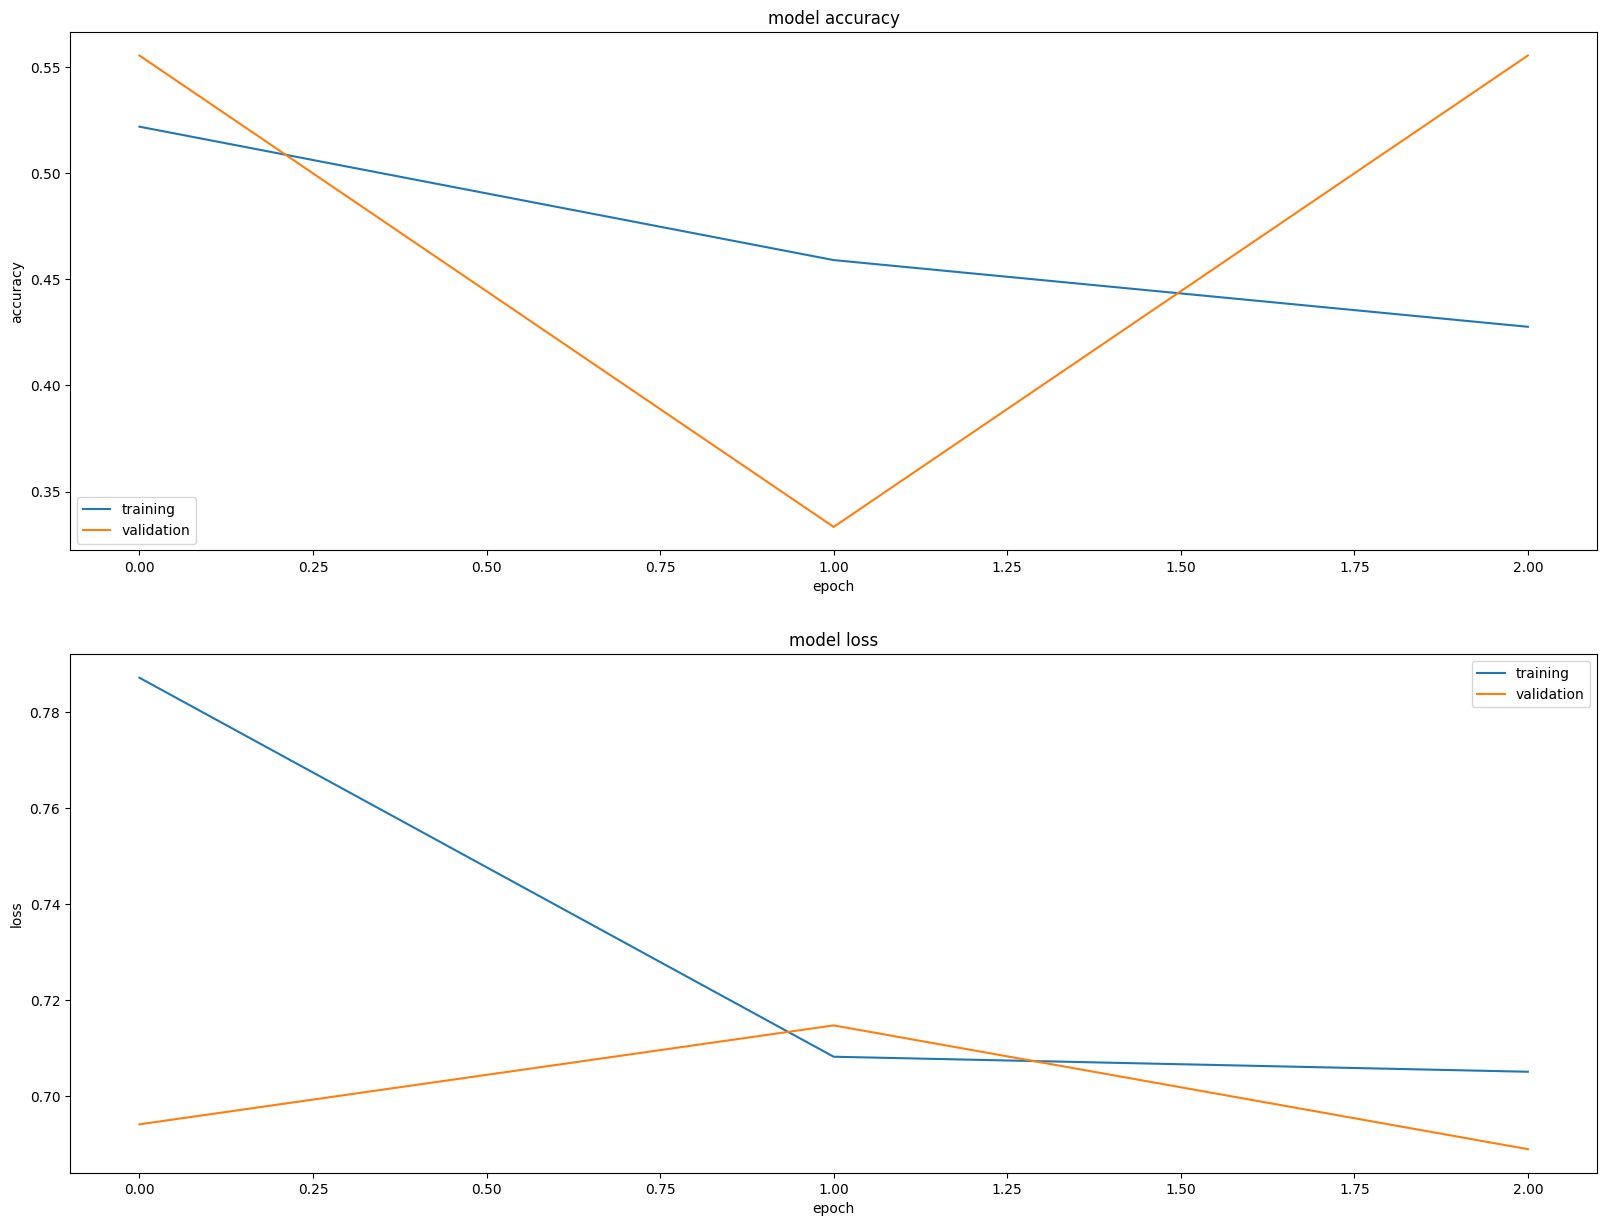

In [90]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Confusion Matrix Post Model Performance Analysis

In [91]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 7s 322ms/step


In [92]:
CLASSES_LIST = ['Positive','Negative']

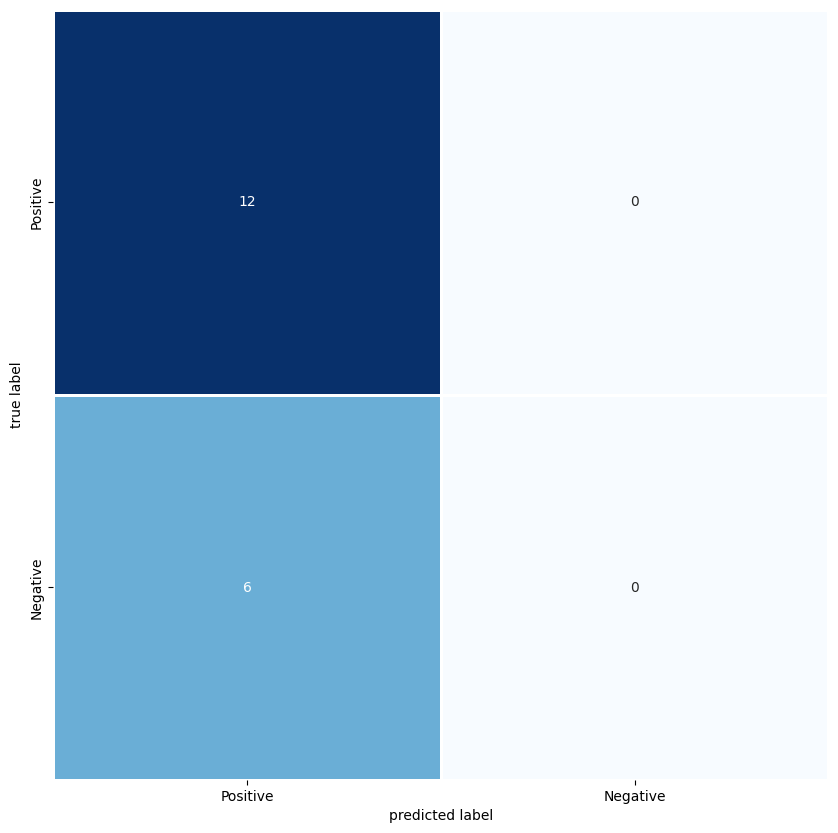

In [93]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [94]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [95]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

ValueError: ignored